In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle
from astropy.table import Table,Column
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 20

In [2]:
C =cosmology.Planck15

## First: generate matrix using labels to keep track

In [3]:
statesto = pd.Index(('BD1', 'RD1', 'RE1'))
statesfrom = pd.Index(('BD1', 'RD1'))
for i in range(2,6):
    statesto=statesto.append(pd.Index(('BD%s'%i,'RD%s'%i,'RE%s'%i)))
for i in range(2,4):
    statesfrom=statesfrom.append(pd.Index(('BD%s'%i,'RD%s'%i)))
statesfrom = statesfrom.append(pd.Index(('BD4','RD4','K')))
rate_labels = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom, data=np.chararray((15,9)))
for frm in statesfrom:
    for to in statesto:
        rate_labels['from '+frm]['to '+to] = '$r_{%s \rightarrow %s}$'%(frm,to)


In [4]:
def rate_matrix_labels(rates):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is a vector - m[0] = m1, m[3] = m4
    rate_mtrx = pd.DataFrame(index=np.linspace(0,2,3),columns=np.linspace(0,2,3),data=np.chararray((3,3)))
    
    rate_mtrx[0][0] = '-$a~sSFR(t)$' + rates['from BD1']['to RD1'] + ' -' +rates['from BD1']['to RE2']

    rate_mtrx[0][1] = rates['from BD1']['to RD1']
    
    rate_mtrx[1][1] = '-' + rates['from RD1']['to RE2']

    rate_mtrx[2][2] = '+/-' + rates['from K']['to RE1']
   
    return rate_mtrx


In [5]:
rm = rate_matrix_labels(rate_labels)
rm

,0.0,1.0,2.0
0,-$a~sSFR(t)$$r_{BD1 \rightarrow RD1}$ -$r_{BD1...,,
1,$r_{BD1 \rightarrow RD1}$,-$r_{RD1 \rightarrow RE2}$,
2,,,+/-$r_{K \rightarrow RE1}$


In [6]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is one mass value
    rate_mtrx = pd.DataFrame(index=np.linspace(0,2,3),columns=np.linspace(0,2,3),data=np.zeros((3,3)))
    a_s = -1.4 
    M_star = 10.82

    rate_mtrx[0][0] =  - alpha(a_s,M_star,m)*sSFR(t) - rates['from BD1']['to RD1'] - rates['from BD1']['to RE2']
 
    rate_mtrx[0][1] = rates['from BD1']['to RD1']
    
    rate_mtrx[1][1] = - rates['from RD1']['to RE2']
    
    rate_mtrx[2][2] = rates['from K']['to RE1']
    
    return rate_mtrx

def modelrates(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def plot_NF(F_RD,F_DR):
    colors = '#008744'
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(12, 6))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4));
    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4));
    plt.tight_layout()

In [7]:
#load dictionary of data; N_RD, N_BD, N_RE, f_RID, f_DIR evolutions for each mass bin
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)


In [8]:
results['m_centers'][-4]

10.25

In [9]:
#centers of bins where f_rid and f_dir are evaluated in the data
z_centers = results['z_centers']
#mass bins
m_centers = results['m_centers'][-4] #just highest mass bin
m = m_centers
#define times/redshifts to compute evolution in model
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value

model_z = [find_nearest(z,i) for i in z_centers[:]] #closest redshift in model to observed redshift values, excluding z=1 
#(z=1 is the input value, will always match model!)
model_z = model_z * 8 #2 for each fraction, 4 for each mass = 16 series 


rate_vector_labels = pd.Index(( ('BD1 to RD1'),
                               ('BD1 to RE2'),
                               ('RD1 to RE2'),
                               ('K to RE1')))

In [10]:
def model_fractions(rate_vector, m_centers):
    # Set rates per galaxy in Gyr^{-1} at fiducial redshift
    rates = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom,data=np.zeros(shape=(15,9)))
    for i in range(1,2):
        rates['from BD{}'.format(i)]['to RD{}'.format(i)]=rate_vector['BD{} to RD{}'.format(i,i)]
        rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['BD{} to RE{}'.format(i,i+1)]
        rates['from K']['to RE{}'.format(i)]=rate_vector['K to RE{}'.format(i)]
        rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['RD{} to RE{}'.format(i,i+1)]

    #set initial values
    states = pd.Index((('BD1'),('RD1'),('RE1')))
    #inital BD, RD, RE for masses 1-4 (z=1)
    N0=pd.Series(index=states)
    for i in range(0,1):
        N0['BD{}'.format(i+1)] = results['M={}'.format(m)]['N_BD'][len(z_centers)-1] #z=1 values
        N0['RD{}'.format(i+1)] = results['M={}'.format(m)]['N_RD'][len(z_centers)-1]
        N0['RE{}'.format(i+1)] = results['M={}'.format(m)]['N_RE'][len(z_centers)-1]    
    N0 /= N0.sum()  # normalise to unity
        
    #evolve numbers from z=1 to z=0.3
    N = odeint(modelrates, N0, t, args=(rates, rate_matrix, m_centers))
    N = pd.DataFrame(index=z, columns=states, data=N)
    N=N[::-1] #number evolution of BD,RD,RE
    
    F_RD = pd.DataFrame(index=N.index) #evolution of fractions
    F_DR = pd.DataFrame(index=N.index) #evolution of fractions

    for i in range(1,2):
        F_RD['$f_{R|D}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['BD{}'.format(i)])
    for i in range(1,2):
        F_DR['$f_{D|R}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['RE{}'.format(i)])

    
    #compare results of fractions at 3 redshifts, for 2 fractions, for all 4 masses, compute chi-squared:
    chi2 = 0

    for i,zc in enumerate(z_centers[:-1]): 
        obs_f_rid = results['M={}'.format(m)]['f_RID'][i]
        obs_f_dir = results['M={}'.format(m)]['f_DIR'][i]
        obs_f_rid_err = results['M={}'.format(m)]['f_RID_err'][i]
        obs_f_dir_err = results['M={}'.format(m)]['f_DIR_err'][i]

        idx = find_nearest(z,zc) #find closest redshift to zc in model
        model_f_rid = F_RD['$f_{R|D}\_%s$'%(1)][idx]
        model_f_dir = F_DR['$f_{D|R}\_%s$'%(1)][idx]
    
        chi2 += ((obs_f_rid - model_f_rid)/obs_f_rid_err)**2
        chi2 += ((obs_f_dir - model_f_dir)/obs_f_dir_err)**2

    #all done! return chi square value for these rates
    #return F_RD, F_DR, chi2
    return chi2

In [11]:
def plot_NF(F_RD,F_DR):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 30
    colors = '#008744'
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(18, 8))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.legend(loc=1,fontsize=20)
    
    #high mass 
    y=results['M={}'.format(m)]['f_RID']
    yerr = results['M={}'.format(m)]['f_RID_err']
    lo = [a-b for a,b in zip(y,yerr)]
    hi = [a+b for a,b in zip(y,yerr)]

    axrd.scatter(model_z[0:4],y,color='#008744',marker='^',s=300)
    axrd.fill_between(model_z[0:4],lo,hi,alpha=.03)

    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4),xlim=(.29,1.1));

    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.legend(loc=1,fontsize=20)

    #high mass 
    y=results['M={}'.format(m)]['f_DIR']
    yerr = results['M={}'.format(m)]['f_DIR_err']
    lo = [a-b for a,b in zip(y,yerr)]
    hi = [a+b for a,b in zip(y,yerr)]

    axdr.scatter(model_z[0:4],y,color='#008744',marker='^',s=300)
    axdr.fill_between(model_z[0:4],lo,hi,alpha=.03)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4),xlim=(.29,1.1));
    plt.tight_layout()

In [12]:
#define rate labels
rate_vector_labels = pd.Index(( ('BD1 to RD1'),
                                ('BD1 to RE2'),
                                ('RD1 to RE2'),
                                ('K to RE1')))

In [13]:
def rate_list(n=10., w=.1):
    #d = bd1 -> rd1
    #h = bd1 -> re2
    #l = rd1 -> re2
    #q = K -> re1
    
    #max rate = +/- 0.1
    #n = number of steps for each rate
    m1=.041
    m2 = .0825
    rate_data = [[round(d*m1+.005,3),
                  round(h*m1+.005,3),
                  round(l*m1+.005,3),
                  round(q*m2-.99,3)] 
                  for d in range(0,25)
                  for h in range(0,25)
                  for l in range(0,25)
                  for q in range(0,25)
             ]
    return rate_data

In [ ]:
r = np.linspace(-.99,.99,25)
m2=r[1]-r[0]
ratedata = [round(i*m2+r[0],3) for i in range(0,25)]
ratedata,m2

(array([ 15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.]),
 array([-0.99  , -0.9108, -0.8316, -0.7524, -0.6732, -0.594 , -0.5148,
        -0.4356, -0.3564, -0.2772, -0.198 , -0.1188, -0.0396,  0.0396,
         0.1188,  0.198 ,  0.2772,  0.3564,  0.4356,  0.5148,  0.594 ,
         0.6732,  0.7524,  0.8316,  0.9108,  0.99  ]),
 <a list of 25 Patch objects>)

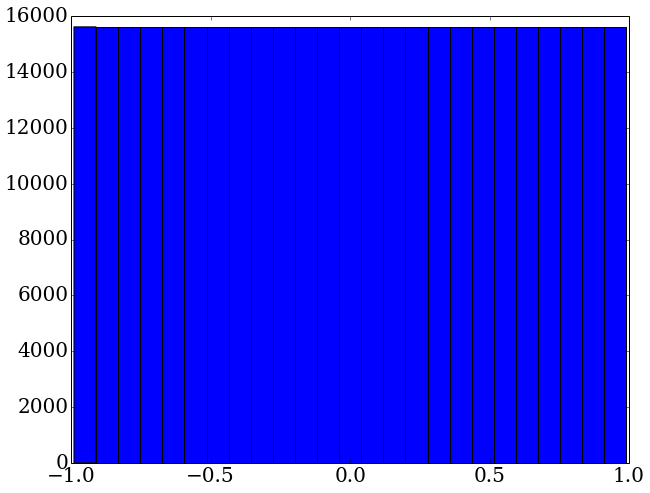

In [14]:
#sanity checks
rate_data = rate_list()

this_rate = [val[3] for val in rate_data]
plt.hist(this_rate,bins=25)

In [15]:
#generate a bunch of combinations of rates, 2 each, maximum rate of 0.1
#rate_data = rate_list()
print 'number of combinations: %s'%len(rate_data)

number of combinations: 390625


In [26]:
#create table to save results
c0 = Column(np.zeros(1),name='chi2') 
c2 = Column(np.zeros(1), name = 'BD1 to RD1')
c4 = Column(np.zeros(1), name = 'BD1 to RE2')
c6 = Column(np.zeros(1), name = 'RD1 to RE2')
c8 = Column(np.zeros(1), name = 'K to RE1')

chi2_table_1d_mass1 = Table()  
chi2_table_1d_mass1.add_columns([c0,c2,c4,c6,c8])


In [16]:
#or: load table
chi2_table_1d_mass1 = Table.read('chi2_table_1d_mass1.fits')
#chi2_table.remove_row(0)
len(chi2_table_1d_mass1)

390626

In [28]:
idx = 351000
rate_data[idx],chi2_table_1d_mass1[idx]

([0.907, 0.456, 0.62, -0.99], <Row index=351000>
      chi2     BD1 to RD1 BD1 to RE2 RD1 to RE2 K to RE1
    float64     float64    float64    float64   float64 
 ------------- ---------- ---------- ---------- --------
 29226.4198995      0.907      0.456       0.62    -0.99)

In [30]:
chi2_table_1d_mass1 = chi2_table_1d_mass1[0:351000]

In [31]:
fname = 'chi2_table_1d_mass1.fits'

import datetime
#test 30,000 rate combos to start 
for i,vector in enumerate(rate_data[351000:]):
    rate_vector = pd.Series(index=rate_vector_labels,data=vector)
    chi2val = model_fractions(rate_vector,m_centers)
    chi2_table_1d_mass1.add_row([chi2val]+vector)
    if i % 1000 ==0:
        print i, chi2val, datetime.datetime.now().strftime('%H:%M:%S.%f')
    if i % 5000 ==0:
        chi2_table_1d_mass1.write(fname,format='fits',overwrite=True)

0 29226.4198995 12:00:26.802379
1000 35002.4457012 12:01:45.887165
2000 27867.2883895 12:03:05.916557
3000 33710.2791005 12:04:28.367287
4000 39373.7583034 12:05:54.076164
5000 32322.2634303 12:07:14.343536
6000 38142.1810265 12:08:35.146840
7000 30813.1258227 12:09:55.597126
8000 36810.4756757 12:11:16.366913
9000 33531.5477125 12:12:31.463085
10000 26917.1204378 12:13:43.142228
11000 32370.1313924 12:14:55.411579
12000 25764.2548505 12:16:11.163589
13000 31157.7435723 12:17:29.880665
14000 36845.1248932 12:18:50.455368
15000 29884.8429204 12:20:08.520454
16000 35645.9612602 12:21:29.772495
17000 28537.2040564 12:22:49.385024
18000 34369.8096804 12:24:10.554971
19000 39991.7358725 12:25:30.922782
20000 32999.2934945 12:26:50.601730
21000 38779.0024341 12:28:14.765634
22000 31509.496936 12:29:35.794329
23000 37467.894663 12:30:57.300353
24000 34136.1241237 12:32:19.009097
25000 27517.1417444 12:33:32.592201
26000 32984.2483259 12:34:46.170731
27000 26367.4363312 12:36:03.126757
28000 3

In [32]:
#chi2_table_1d_mass1.remove_row(0)
chi2_table_1d_mass1.write(fname,format='fits',overwrite=True) #once more for good measure

In [13]:
find_nearest_idx(chi2_table_1d_mass1['chi2'],np.min(chi2_table_1d_mass1['chi2']))

15011

In [14]:
#plot a few of the best values
def plot_best_values(rank):
    #rank = 0 for lowest chi2, 1 for second lowest, etc. 
    rate_list = []
    for val in chi2_table_1d_mass1[rank]:
        rate_list.append(val)
    rate_list = rate_list[1:]
    rate_vector = pd.Series(index=rate_vector_labels,data=rate_list) #rate combo with best chi2
    F_RD,F_DR,chi2val = model_fractions(rate_vector,m)
    plot_NF(F_RD,F_DR)

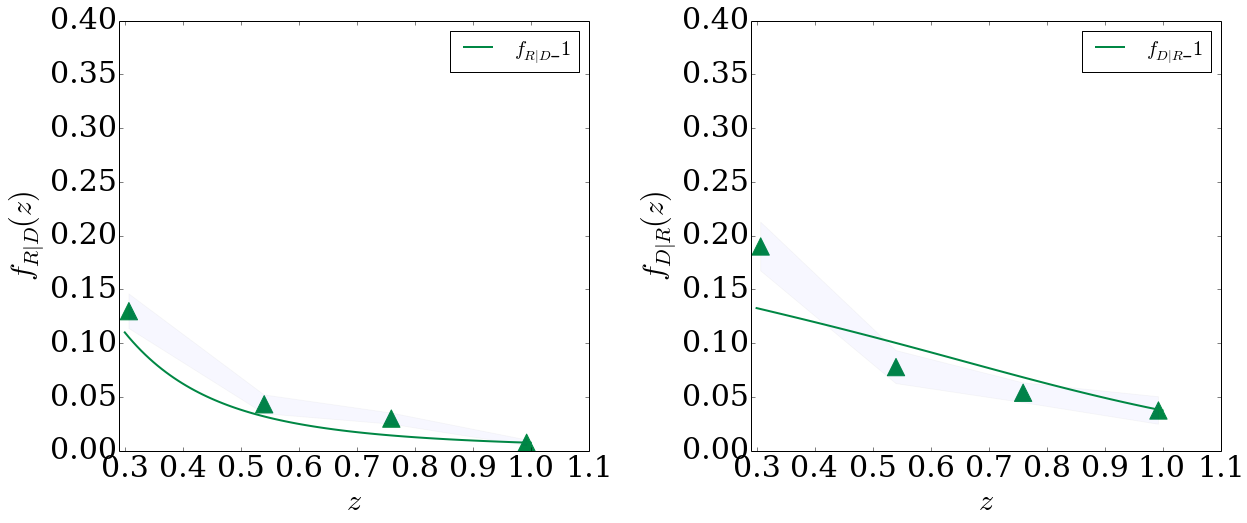

In [17]:
plot_best_values(15011)


In [1]:
chi2_table_1d_mass1[15011]

NameError: name 'chi2_table_1d_mass1' is not defined